# Transformer Training

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from protein_transformer.tokenizer import Tokenizer
from protein_transformer.modules import Encoder, EncoderLayer, PositionalEncoding
from protein_transformer.model import Transformer

/Users/karinazad/miniforge3/envs/armpytor/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
params = {
    "max_len": 511,
    "embedding_dim": 100,
    "lr": 0.0001,
    "num_warmup_steps": 16000,
}

## Load Data

In [5]:
data = [
    "ANDEQLIKFSSST",
    "STQYVRNDC",
    "AAAAREEEQQ",
    "ASTMF",
    "NDCEMQY",
    "ANDEQLIKFT",
    "ANDEQFSSST",
    "EQFSSST",
    "ASTMF",
    "FFFASTMF",
    "EQFSSST",
    "ARG",
    "NDCEMQY",
    "ANDEQLIKFT",
    "ANDEQFSSST",
]

len(data)
data = [ "ANDEQLIKFSSST"]

In [6]:
from Bio import SeqIO

data_path = "../data/rcsb_pdb_7R3V.fasta"
fasta_sequences = SeqIO.parse(open(data_path),'fasta')

sequences = [str(fasta_entry.seq) for fasta_entry in fasta_sequences]
data = [sequences[0]]

### Tokenize

In [7]:
print("Max length in data: ", max([len(seq) for seq in data]))
print("Number of sequences: ", len(data))

# Tokenize the sequences
tokenizer = Tokenizer(max_seq_length=params.get("max_len"))
X = tokenizer.batch_encode(data)
X = torch.from_numpy(X)

# max_final_length = X.size(1)
print("\nMax final length (with special tokens): ", tokenizer.max_seq_length)
print("Size after tokenization ", X.size())

Max length in data:  445
Number of sequences:  1

Max final length (with special tokens):  512
Size after tokenization  torch.Size([1, 512])


### Visualize Positional Encoding

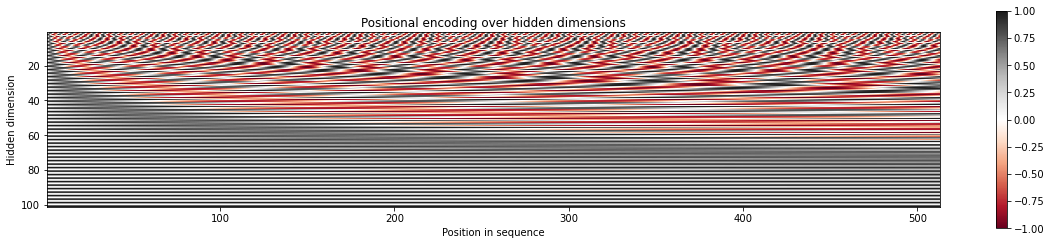

In [8]:
from protein_transformer.utils import display_positional_encoding

pe_layer = PositionalEncoding(embed_dim=params.get("embedding_dim"), max_len=tokenizer.max_seq_length)
pe = pe_layer.pos_emb.squeeze().cpu().numpy()
display_positional_encoding(pe)

### PL Trainer

In [9]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import wandb

In [11]:
wandb_logger = WandbLogger(name='overfit-single-len-512-cosine-warmup-2layer-output-net',project='protein-transformer')
train_loader = torch.utils.data.DataLoader(X,  batch_size=1)

transformer = Transformer(tokenizer, percent_sequences=1)
trainer = Trainer(max_epochs=5000, logger= wandb_logger, log_every_n_steps=1)
trainer.fit(model=transformer, train_dataloaders=train_loader)

/Users/karinazad/miniforge3/envs/armpytor/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params
--------------------------------------------------
0 | embedding  | Embedding          | 2.4 K 
1 | pe         | PositionalEncoding | 0     
2 | encoder    | Encoder            | 242 K 
3 | output_net | FeedForwardNet     | 12.7 K
--------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.031     Total estimated model params size (MB)


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s, loss=0.377, v_num=mpq4]


In [ ]:
# transformer = Transformer(tokenizer)
#
# out = transformer(X, logits=True)[0]
# proba = F.softmax(out, dim=1)
#
# # Sum all columns for each position (proba for each of 24 classes) in a sequence and check that the sum = 1
# print(torch.sum(proba, dim=1))
#
# plt.imshow(proba.detach().numpy())
# plt.xticks(np.arange(len(tokenizer.all_tokens)))
# plt.yticks(np.arange(tokenizer.max_seq_length))
# plt.xlabel(tokenizer.all_tokens)
# plt.ylabel("Position in a sequence")
# plt.colorbar()
# plt.show()

In [ ]:
# # Try the attention module on a single input
#
# multihead_attn = nn.MultiheadAttention(embed_dim=100, num_heads=1)
# attn_output, attn_output_weights = multihead_attn(X_pos[0], X_pos[0], X_pos[0])
#
# print("Attention output size: ", attn_output.size()) # [num sequences, max len, embedding dim]
# print("Attention weights size: ", attn_output_weights.size()) # [num sequences, max len, embedding dim]
# plt.imshow(attn_output_weights.detach().numpy())


In [ ]:
# trainer.save_checkpoint('test.pth')
# wandb.save('test.pth')